In [1]:
from utils.dataset import  CustomDataset
import os
import warnings
warnings.filterwarnings("ignore")
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import sys
import pandas as pd
from tqdm import tqdm
import threading
import random
# import rasterio
import os
import numpy as np
import sys
from sklearn.utils import shuffle as shuffle_lists
import numpy as np
from sklearn.model_selection import train_test_split
import joblib

import torch

#default
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

#trasnform
from torchvision import transforms

#dataset
from utils.dataset import Custom_test_Dataset
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from torchsummary import summary
from torchsampler import ImbalancedDatasetSampler


from utils import models 
#metric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import torchmetrics.functional as tf

#numeric
import numpy as np
import pandas as pd 

#visualization
import matplotlib.pyplot as plt

#system 
from tqdm import tqdm
import os 
import wandb
import datetime

# random seed 고정
random.seed(42)
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.manual_seed_all(42)
else:
    device = torch.device('cuda')
    torch.manual_seed_all(42)




In [2]:
test_csv = '../../dataset/test_meta.csv'

test_transform = transforms.Compose([
    # transforms.Resize((512,512), antialias= True),
    # transforms.RandomApply([
    #     transforms.RandomRotation(degrees = 30),
    #     transforms.RandomVerticalFlip(p= 0.5),
    #     transforms.RandomVerticalFlip(p=0.5),
    #     transforms.RandomCrop(size =224, scale= (0.8, 1.2), ratio = (0.75, 1.2), antialias = True),
    #     transforms.ColorJitter(brightness= 0.2, contrast = 0.2)
    # ]),
    transforms.ToTensor()
])
ts_batch = 1

dataset = Custom_test_Dataset(
    csv_path= test_csv,
    transform= None, #None으로 세팅
    MAX_PIXEL_VALUE= 65535,
    band = (7,6,2) #기존 세팅 
)

# 훈련 및 검증 세트 분할
test_loader = DataLoader(dataset = dataset, batch_size = ts_batch, shuffle= True)



torch.Size([1, 256, 256, 3])


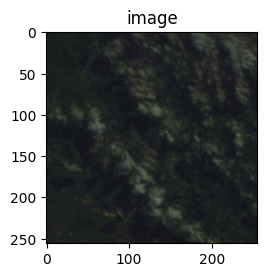

In [3]:
for images, name in test_loader:
    print(images.shape)
    idx = 0
    name= name[idx].split('/')[-1]
    plt.figure(figsize=(6,4))
    plt.subplot(121)
    plt.imshow(images[idx])
    plt.title('image')
    # plt.subplot(122)
    # plt.imshow(masks[idx], cmap= 'gray')
    # plt.title('mask')
    plt.show()
    break


In [4]:
def load_checkpoint(load_dir, index = 23, extension = 'pt'):
    files = [os.path.join(load_dir, file) for file in os.listdir(load_dir) if file.endswith(extension)]
    
    file = [item for item in files if '_'+str(index)+'_' in item][0]
    # files = sorted(files, reverse= True )
    
    checkpoint = torch.load(file)
    return checkpoint['model_state_dict'], file

def plot_pred(images, masks):
    plt.figure(figsize=(8,6))
    plt.subplot(121)
    plt.imshow(images[0].permute(1, 2, 0).cpu().detach().numpy())
    plt.title('image')
    plt.subplot(122)

    plt.imshow(masks, cmap = 'gray')
    plt.title('pred')
    plt.tight_layout()
    plt.show()
    
LOAD_DIR = '../../satellite_model/unet_v2[95:5]_240316/'

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=False)
model.to(device)

checkpoint, checkpoint_path = load_checkpoint(LOAD_DIR, index = 52)
model.load_state_dict(checkpoint)

pkl_save = checkpoint_path.replace('pt','pkl')
print("Complete Load weights")

Using cache found in /home/eiden/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


Complete Load weights


In [5]:
y_pred_dict = {}

model.eval()
with torch.no_grad():
    for idx, (images, names) in tqdm(enumerate(test_loader), total = len(test_loader)):
        images = images.permute(0,3,1,2).to(device)
        name= names[-1].split('/')[-1]
        
        y_pred = model(images) #pred type : tensor
        masks = np.where(y_pred[0,0].cpu().detach().numpy() >0.25, 1, 0) # tesnor to array
        masks = masks.astype(np.uint8) # astype
        
        y_pred_dict[name] = masks # save 

        # plot_pred(images= images, masks =masks) #if you want to see mask 
        # break
    joblib.dump(y_pred_dict, pkl_save)
print(f"SAVE_Pickle PATH : {pkl_save}")


100%|██████████| 4000/4000 [00:24<00:00, 163.19it/s]


SAVE_Pickle PATH : ../../satellite_model/unet_v2[95:5]_240316/202403160146_52_200.pkl
